In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os 
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adamax
from tensorflow.keras.losses import categorical_crossentropy
import cv2

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2023-07-27 12:10:27.106077: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 12:10:27.164043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 12:10:27.164912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 12:10:28.081876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BASEDIR = os.getcwd()
DATADIR = os.path.join(BASEDIR, 'data')

In [3]:
DATADIR

'/home/dhakal/BTC_TF/data'

In [4]:
for dirs in [DATADIR]:
    filepaths = []
    labels = []
    classes_list = sorted(os.listdir(dirs))
    for s_class in classes_list:
        label = s_class
        classpath = os.path.join(dirs,s_class)
        f_list = sorted(os.listdir(classpath))
        for file in f_list:
            file_path = os.path.join(classpath,file)
            filepaths.append(file_path)
            labels.append(label)

In [5]:
main_df = pd.DataFrame({'image_path' : filepaths, 'label': labels})

In [6]:
main_df.head()

,image_path,label
0,/home/dhakal/BTC_TF/data/Astrocitoma T1/005_bi...,Astrocitoma T1
1,/home/dhakal/BTC_TF/data/Astrocitoma T1/006_bi...,Astrocitoma T1
2,/home/dhakal/BTC_TF/data/Astrocitoma T1/01809e...,Astrocitoma T1
3,/home/dhakal/BTC_TF/data/Astrocitoma T1/02df13...,Astrocitoma T1
4,/home/dhakal/BTC_TF/data/Astrocitoma T1/044d8d...,Astrocitoma T1


In [7]:
len(main_df['label'].unique())

44

In [8]:
main_df.shape

(4479, 2)

In [9]:
main_df['label'].value_counts()

label
Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Astrocitoma T1C+          233
Meningioma T2             233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               73
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinoma T1C+             40
Tube

In [10]:
image_size = 150
data = []
for img in main_df['image_path']:
    image = cv2.imread(img)
    image = cv2.resize(image,(image_size,image_size))
    image = np.array(image/255)
    data.append(image)

In [11]:
data = np.array(data)

In [12]:
data.shape

(4479, 150, 150, 3)

In [13]:
labels = np.array(main_df['label'])

In [14]:
labels.shape

(4479,)

In [15]:
labels

array(['Astrocitoma T1', 'Astrocitoma T1', 'Astrocitoma T1', ...,
       '_NORMAL T2', '_NORMAL T2', '_NORMAL T2'], dtype=object)

In [16]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [17]:
(trainX, testX, trainY, testY) = train_test_split(np.array(data),
    np.array(labels), test_size=0.25)
print(trainX.shape)
print(testX.shape)

(3359, 150, 150, 3)
(1120, 150, 150, 3)


In [18]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'same', activation= 'relu',
                         input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'same', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'same', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'same', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

In [19]:
model = AlexNet((150, 150, 3), 44)

2023-07-27 12:10:49.781845: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
opt = Adamax (learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 19, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 384)       132

In [21]:
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=32)

Epoch 1/50
105/105 [==============================] - 51s 473ms/step - loss: 3.2313 - accuracy: 0.1533 - val_loss: 2.8302 - val_accuracy: 0.2366
Epoch 2/50
105/105 [==============================] - 44s 420ms/step - loss: 2.4084 - accuracy: 0.3578 - val_loss: 2.2009 - val_accuracy: 0.4196
Epoch 3/50
105/105 [==============================] - 43s 414ms/step - loss: 1.8343 - accuracy: 0.4987 - val_loss: 1.7072 - val_accuracy: 0.5375
Epoch 4/50
105/105 [==============================] - 44s 419ms/step - loss: 1.4030 - accuracy: 0.6070 - val_loss: 1.4265 - val_accuracy: 0.5946
Epoch 5/50
105/105 [==============================] - 43s 407ms/step - loss: 1.0570 - accuracy: 0.6993 - val_loss: 1.1768 - val_accuracy: 0.6902
Epoch 6/50
105/105 [==============================] - 42s 404ms/step - loss: 0.7899 - accuracy: 0.7862 - val_loss: 1.0571 - val_accuracy: 0.7161
Epoch 7/50
105/105 [==============================] - 43s 406ms/step - loss: 0.6279 - accuracy: 0.8273 - val_loss: 0.9583 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


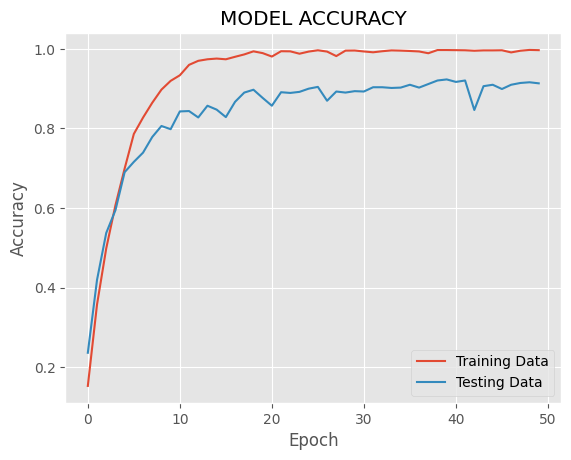

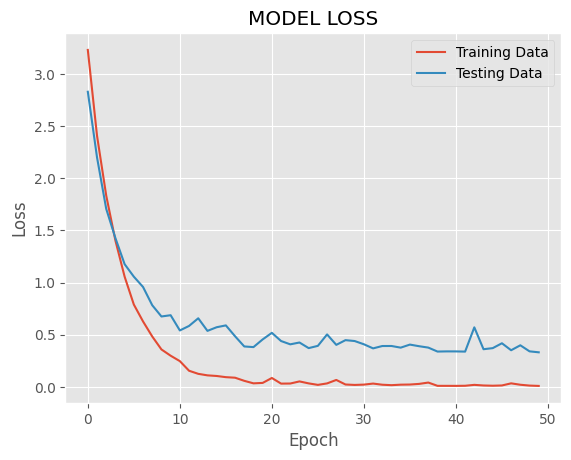

In [23]:
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('MODEL ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Testing Data'], loc='lower right')
X = np.linspace(0, 100, 100)
# plt.ylim(.1, 1.1)
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Testing Data'], loc='upper right')
X = np.linspace(0, 100, 100)
# plt.ylim(-0.25, 1.75)
plt.show()